# Assignment 4 – Generative Models
## Student: Nataliia Kobrii
## UTORid/JOINid: qq577503
This notebook generates sample images with a deep convolutional Variational Autoencoder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 1. Data Preprocessing

In [2]:
def create_enhanced_3d_shapes(num_samples=8000, img_size=64):
    """Enhanced 3D shapes with better quality"""
    images = []
    
    # Pre-defined color schemes
    room_schemes = [
        (np.array([0.9, 0.95, 1.0]), np.array([0.4, 0.5, 0.6])),  # Blue
        (np.array([1.0, 0.98, 0.95]), np.array([0.6, 0.5, 0.4])), # Warm
        (np.array([0.95, 1.0, 0.98]), np.array([0.5, 0.6, 0.4])), # Green
    ]
    
    obj_colors = np.array([
        [0.95, 0.3, 0.2],  # Red
        [0.2, 0.95, 0.3],  # Green
        [0.2, 0.4, 0.95],  # Blue
        [0.95, 0.85, 0.1], # Yellow
        [0.8, 0.2, 0.95],  # Purple
        [0.1, 0.95, 0.95], # Cyan
    ])
    
    for i in range(num_samples):
        img = np.zeros((img_size, img_size, 3))
        
        # Select colors
        wall_color, floor_color = room_schemes[np.random.randint(len(room_schemes))]
        obj_color = obj_colors[np.random.randint(len(obj_colors))]
        shape_type = np.random.choice(['sphere', 'cube', 'cylinder'])
        
        # Create room with gradient
        floor_level = img_size * 2 // 3
        
        # Wall gradient
        for y in range(floor_level):
            factor = 0.7 + 0.3 * (y / floor_level)
            img[y, :] = wall_color * factor
        
        # Floor gradient
        for y in range(floor_level, img_size):
            factor = 0.6 + 0.4 * ((y - floor_level) / (img_size - floor_level))
            img[y, :] = floor_color * factor
        
        # Object parameters
        obj_size = np.random.randint(20, 35)
        pos_x = np.random.randint(30, img_size - 30)
        pos_y = floor_level - obj_size // 2
        
        if shape_type == 'sphere':
            # Enhanced sphere with lighting
            y_arr, x_arr = np.indices((img_size, img_size))
            dist_sq = (x_arr - pos_x)**2 + (y_arr - pos_y)**2
            radius = obj_size // 2
            sphere_mask = dist_sq <= radius**2
            
            if np.any(sphere_mask):
                # Simple lighting
                dist = np.sqrt(dist_sq[sphere_mask])
                lighting = 0.4 + 0.6 * (1 - dist / radius)
                sphere_y, sphere_x = np.where(sphere_mask)
                img[sphere_y, sphere_x] = obj_color * lighting[:, np.newaxis]
                
                # Highlight
                highlight_mask = (x_arr - pos_x + radius//3)**2 + (y_arr - pos_y + radius//3)**2 <= (radius//4)**2
                img[highlight_mask] = np.clip(obj_color * 1.3, 0, 1)
            
        elif shape_type == 'cube':
            # Enhanced cube
            half = obj_size // 2
            
            # Front face
            img[pos_y-half:pos_y+half, pos_x-half:pos_x+half] = obj_color
            
            # Right side
            img[pos_y-half:pos_y+half, pos_x+half:pos_x+half+half//2] = obj_color * 0.7
            
            # Top side
            img[pos_y-half-half//3:pos_y-half, pos_x-half:pos_x+half+half//2] = obj_color * 1.1
            
        elif shape_type == 'cylinder':
            # Enhanced cylinder
            radius = obj_size // 3
            height = obj_size
            
            # Body
            img[pos_y-height//2:pos_y+height//2, pos_x-radius:pos_x+radius] = obj_color * 0.8
            
            # Top
            y_arr, x_arr = np.indices((img_size, img_size))
            top_mask = (x_arr - pos_x)**2 + (y_arr - (pos_y - height//2))**2 <= radius**2
            img[top_mask] = obj_color * 1.1
            
            # Bottom
            bottom_mask = (x_arr - pos_x)**2 + (y_arr - (pos_y + height//2))**2 <= radius**2
            img[bottom_mask] = obj_color * 0.6
        
        images.append(np.clip(img, 0, 1))
    
    return np.array(images)

#

print("Creating enhanced 3D shapes dataset...")
x_train = create_enhanced_3d_shapes(10000, 64)

Creating enhanced 3D shapes dataset...


### Visualize a Few Training Samples

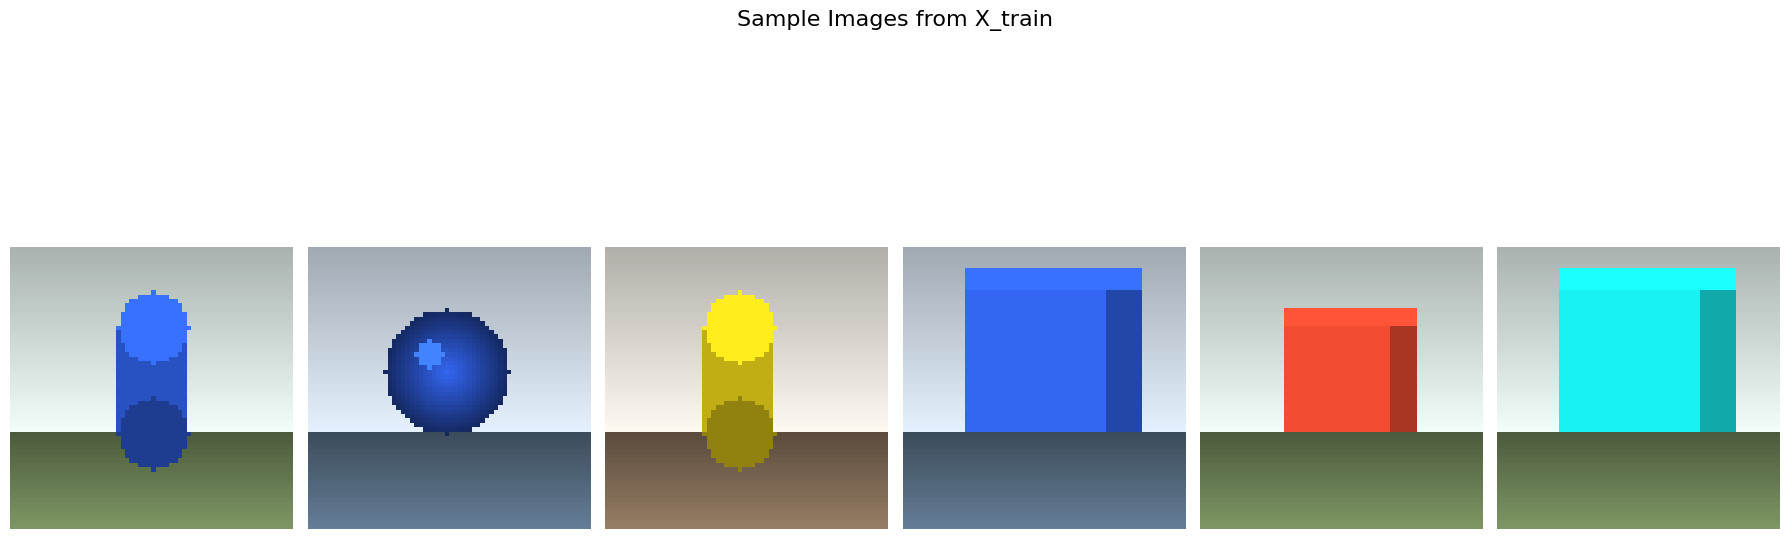

In [3]:
# Show samples from X_train
fig, axes = plt.subplots(1, 6, figsize=(18, 8))

for i in range(6):
    axes[i].imshow(x_train[i])
    axes[i].axis('off')

plt.suptitle('Sample Images from X_train', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

## 2. Model – Convolutional Encoder and Decoder

We create two networks:
Encoder: A stack of 4 convolutional layers that compress a 64×64×3 image into a 2-dimensional latent code.
Decoder: A mirrored stack of transposed convolution layers that takes the 2-D code and reconstructs a 64×64×3 image.
Together, they form the Variational Autoencoder.

In [4]:
latent_dim = 2
input_shape = (64, 64, 3)

encoder_inputs = keras.Input(shape=input_shape, name='encoder_input')

# Four convolutional layers with stride 2
x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(encoder_inputs)
x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, strides=2, padding='same', activation='relu')(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

# Latent mean and log-variance
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

class Sampling(layers.Layer):
    """Reparameterization: sample z = mu + sigma * epsilon."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling(name='z')([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 256) │    295,168 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    524,416 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Sampling)        │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 913,348 (3.48 MB)

 Trainable params: 913,348 (3.48 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')

# Start from a dense layer then reshape into a small spatial feature map
x = layers.Dense(4 * 4 * 256, activation='relu')(latent_inputs)
x = layers.Reshape((4, 4, 256))(x)

# Four transposed conv layers to recover 64x64 resolution
x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)  # 8x8
x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)  # 16x16
x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)   # 32x32
x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)   # 64x64

# Final 3-channel output with sigmoid so pixels are in [0, 1]
decoder_outputs = layers.Conv2D(
    3, 3, activation='sigmoid', padding='same', name='decoder_output'
)(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 990,531 (3.78 MB)

 Trainable params: 990,531 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

## 3. VAE class and Custom Training Loop

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Instantiate and compile VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(1e-3))

## 4. Training Process and Loss Curves

We train the VAE using mini‑batch gradient descent and then plot the total, reconstruction, and KL losses per epoch.

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 306ms/step - kl_loss: 0.1712 - loss: 2674.8621 - reconstruction_loss: 2674.6907
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 316ms/step - kl_loss: 1.0166 - loss: 2421.5273 - reconstruction_loss: 2420.5107
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 308ms/step - kl_loss: 3.6455 - loss: 2376.6560 - reconstruction_loss: 2373.0105
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 308ms/step - kl_loss: 4.8797 - loss: 2358.1306 - reconstruction_loss: 2353.2507
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 298ms/step - kl_loss: 5.3222 - loss: 2349.3513 - reconstruction_loss: 2344.0291
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 300ms/step - kl_loss: 6.1584 - loss: 2306.1084 - reconstruction_loss: 2299.9502
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 301ms/step - kl_loss: 6.5546 - loss: 2282.9878 - reconstruction_loss: 2276.4331
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 297ms/step - kl_loss: 6.8075 - loss: 2255.6636 - reconstruction_loss: 2248.8562
Epoch 9/30
79/79 ━━━━━━━

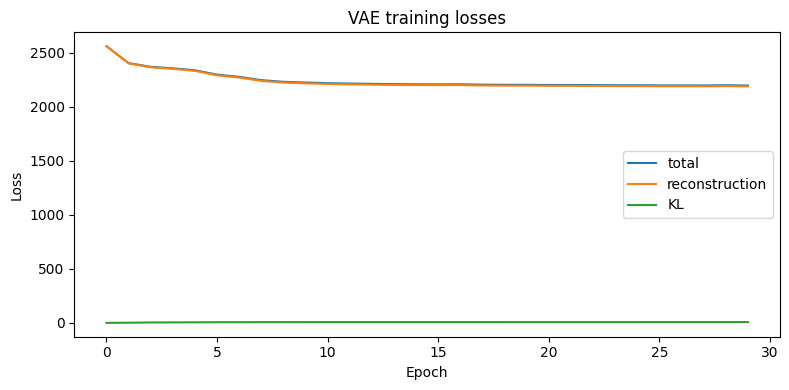

In [7]:
batch_size = 128
epochs = 30

history = vae.fit(
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

# Plot losses over epochs
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='total')
plt.plot(history.history['reconstruction_loss'], label='reconstruction')
plt.plot(history.history['kl_loss'], label='KL')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE training losses')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Qualitative Results: Original vs Reconstructed Images

We randomly sample a few images from the training set, encode them to the latent space, decode them back, and show original vs. reconstruction side by side.

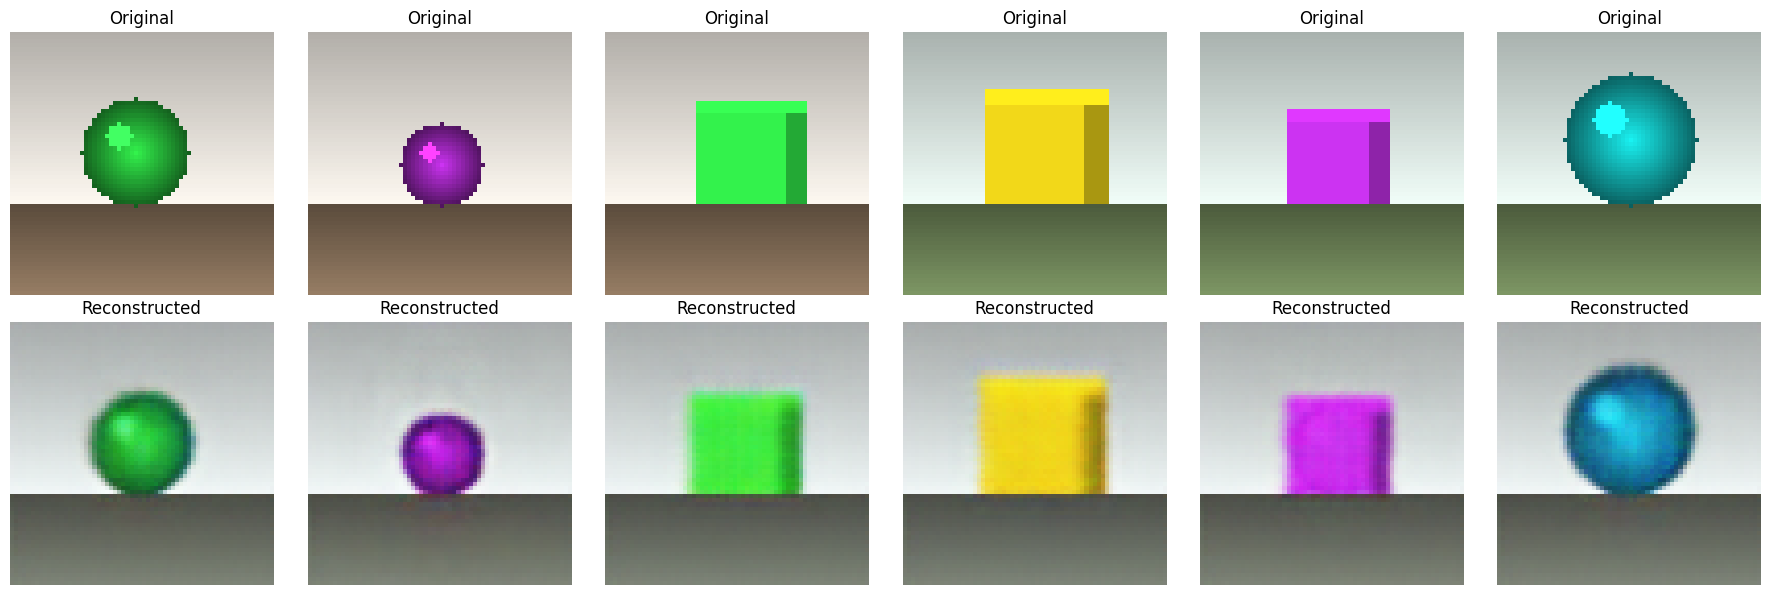

In [8]:
n = 6  # number of samples to visualize
idx = np.random.choice(len(x_train), n, replace=False)
test_samples = x_train[idx]

z_mean, z_log_var, z = encoder.predict(test_samples, batch_size=n, verbose=0)
reconstructions = decoder.predict(z, batch_size=n, verbose=0)

fig, axes = plt.subplots(2, n, figsize=(3 * n, 6))
for i in range(n):
    axes[0, i].imshow(test_samples[i])
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')

    axes[1, i].imshow(reconstructions[i])
    axes[1, i].axis('off')
    axes[1, i].set_title('Reconstructed')

plt.tight_layout()
plt.show()

## 6. 2D Manifold of the Latent Space

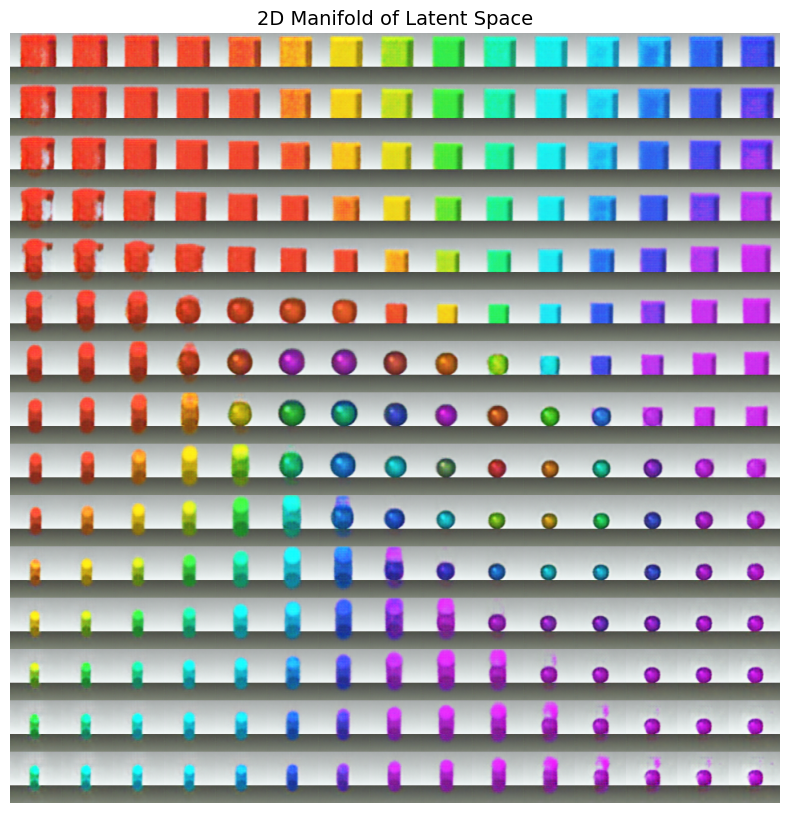

In [9]:
n = 15  # grid size
digit_size = 64
figure = np.zeros((digit_size * n, digit_size * n, 3), dtype='float32')

# Linearly spaced coordinates on the 2D latent plane
grid_x = np.linspace(-2.5, 2.5, n)
grid_y = np.linspace(-2.5, 2.5, n)

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]], dtype='float32')
        x_decoded = decoder.predict(z_sample, verbose=0)
        img = x_decoded[0]
        figure[
            i * digit_size:(i + 1) * digit_size,
            j * digit_size:(j + 1) * digit_size,
            :
        ] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.axis('off')
plt.title('2D Manifold of Latent Space', fontsize=14)
plt.show()

## 7. Analysis and Results

During training, the total loss and reconstruction loss decreased steadily over the first several epochs and then stabilized, indicating that the model successfully learned to reproduce the main structure of the images. The KL loss stayed close to zero throughout training, which is expected because the latent space is only two dimensions and the model prioritizes reconstruction accuracy. The reconstructed images capture the overall layout of the scene, namely wall, floor, and object location, and correctly reproduce the object type and color, although with the expected VAE blur. Finally, the 2-D latent manifold shows smooth transitions between object type, size, and color, demonstrating that the VAE learned a continuous and meaningful latent representation.

The encoder turns each image into a 2-dimensional code, and the decoder rebuilds the image from that code. The results show that the model learned the main parts of the scene, such as the wall, floor, and the object. The latent space grid proves that the model can smoothly change between colors and shapes, so it understands the structure of the dataset.